# Dating Prediction

## Loading Data

In [232]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

df = pd.read_csv("profiles.csv")
print(df.columns)
print(df.head())

print(df["smokes"].value_counts())
print(df["drinks"].value_counts())
print(df["drugs"].value_counts())

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')
   age       body_type               diet    drinks      drugs  \
0   22  a little extra  strictly anything  socially      never   
1   35         average       mostly other     often  sometimes   
2   38            thin           anything  socially        NaN   
3   23            thin         vegetarian  socially        NaN   
4   29        athletic                NaN  socially      never   

                           education  \
0      working on college/university   
1              working on space camp   
2     graduated from masters program   
3      working on college/university   
4  graduated from college

Mapping value to int

In [233]:
# Mapping str values to numerical
df["drinks"] = df["drinks"].replace(np.nan,'not at all',regex=True)
df["drinks_code"] = df.drinks.map({
    "not at all" : 0,
    "rarely" : 1,
    "socially" : 2,
    "often" : 3,
    "very often" : 4,
    "desperately" : 5
})

df["smokes"] = df["smokes"].replace(np.nan,'no',regex=True)
df["smokes_code"] = df.smokes.map({
    "no":0,
    "sometimes":1,
    "when drinking":2,
    "yes":3,
    "trying to quit":4
})

df["drugs"] = df["drugs"].replace(np.nan,'never',regex=True)
df["drugs_code"] = df.drugs.map({
    "never":0,
    "sometimes":1,
    "often":2
})

Mapping essays columns

In [234]:
# Retrieve the essays cols
essays_cols = ["essay0","essay1","essay2","essay3","essay4","essay5",
               "essay6","essay7","essay8","essay9"]

# Removing the NaNs
all_essays = df[essays_cols].replace(np.nan,'',regex=True)

# Combining the essays
all_essays = all_essays.apply(lambda x:' '.join(x),axis=1)

# Total length of the ssays
df["essay_len"] = all_essays.apply(lambda x : len(x))

# Average length for essays
df["avg_word_length"] = df["essay_len"]/len(essays_cols)

# Frequency of the words 'I' or 'me"
df["common_words"] = all_essays.str.count(r'\b(I|me)\b', flags=re.IGNORECASE)

### Normalize Data

In [235]:
feature_data = df[["smokes_code","drinks_code","drugs_code",
                   "essay_len","avg_word_length"]]

x = feature_data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

### Predict Zodiac Signs

In [236]:
df["sign"] = df["sign"].replace(np.nan,'',regex=True)

# Only take the first word, which is the zodiac sign only
df["sign"] = (df["sign"].apply(lambda x: x.split(" ")[0]))

X_train, X_test, y_train, y_test = train_test_split(feature_data,df["sign"],test_size=0.2,random_state=100)

accuracies = []

# for k in range(1,200):
#     classifier = KNeighborsClassifier(n_neighbors=k)
#     classifier.fit(X_train,y_train)
#     accuracies.append(classifier.score(X_test,y_test))

# k_list = range(1,200)

# plt.plot(k_list,accuracies)
# plt.xlabel("k")
# plt.ylabel("Accuracy")
# plt.show()
# fig = plt.figure(figsize=(6,4))
# plt.savefig("k_accuracy.png")

## Classification Techniques

### Predict Sex with education level and income

In [237]:
# Male = 0 , Female = 1
df["sex"] = df.sex.map({
    "m" : 0,
    "f" : 1
})

In [238]:
print(df["education"].value_counts())
print(df["sex"].value_counts())

# Todo: map education and income to int


graduated from college/university    23959
graduated from masters program        8961
working on college/university         5712
working on masters program            1683
graduated from two-year college       1531
graduated from high school            1428
graduated from ph.d program           1272
graduated from law school             1122
working on two-year college           1074
dropped out of college/university      995
working on ph.d program                983
college/university                     801
graduated from space camp              657
dropped out of space camp              523
graduated from med school              446
working on space camp                  445
working on law school                  269
two-year college                       222
working on med school                  212
dropped out of two-year college        191
dropped out of masters program         140
masters program                        136
dropped out of ph.d program            127
dropped out

### Predict education level with essay text word counts

## Regression Techniques

### Predict income with length of essays and average word length

20033
20033      48442
20000       2952
100000      1621
80000       1111
30000       1048
40000       1005
50000        975
60000        736
70000        707
150000       631
1000000      521
250000       149
500000        48
Name: income, dtype: int64


/Users/yiyimeow/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/yiyimeow/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

Train score:  0.8082617399282676


/Users/yiyimeow/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Test score:  0.8074228523769809


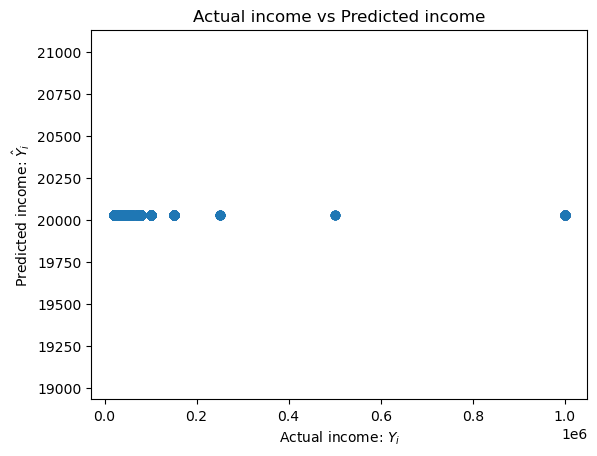

In [239]:
features = df[["essay_len","avg_word_length"]]

mean_income =int(df["income"].mean())
df["income"] = df["income"].replace(-1,mean_income)
print(df["income"].value_counts())

X_train, X_test, y_train, y_test = train_test_split(features,df["income"],train_size=0.8,test_size=0.2,random_state=6)
clasifier = LinearRegression()
classifier.fit(X_train,y_train)
income_predict = classifier.predict(X_test)

print("Train score: ", classifier.score(X_train,y_train))
print("Test score: ", classifier.score(X_test,y_test))

plt.scatter(y_test,income_predict)
# plt.plot(range(20000),range(20000))

plt.xlabel("Actual income: $Y_i$")
plt.ylabel("Predicted income: $\hat{Y}_i$")
plt.title("Actual income vs Predicted income")

plt.show()
